Note: you may need to restart the kernel to use updated packages.


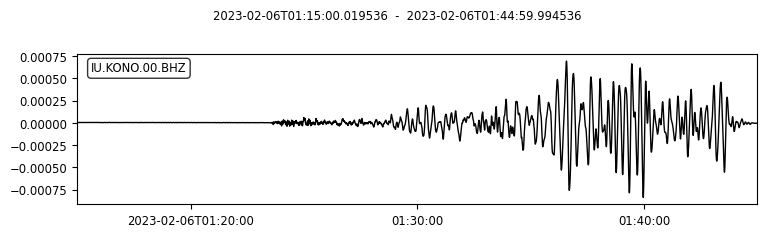

/opt/miniconda3/envs/mapmaking_env/lib/python3.11/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Note: you may need to restart the kernel to use updated packages.
snuffler:pyrocko.gui.snuffler.snuffler - CRITICAL - 

Missing Pyrocko requirement: PyQt5

The Python package 'PyQt5' is required to run this program, but it doesn't seem to
be available or an error occured while importing it. Use your package manager
of choice (apt / yum / conda / pip) to install it. To verify that 'PyQt5' is
available in your Python environment, check that "python -c 'import PyQt5.Qt'"
exits without error. The original error was:

  No module named 'PyQt5'



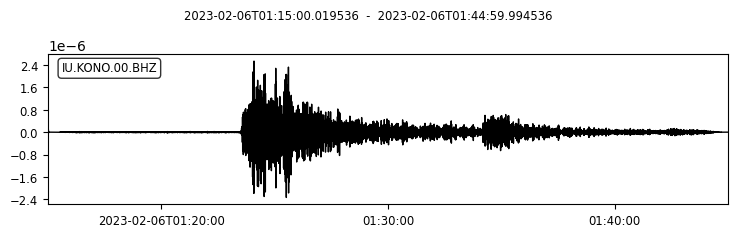

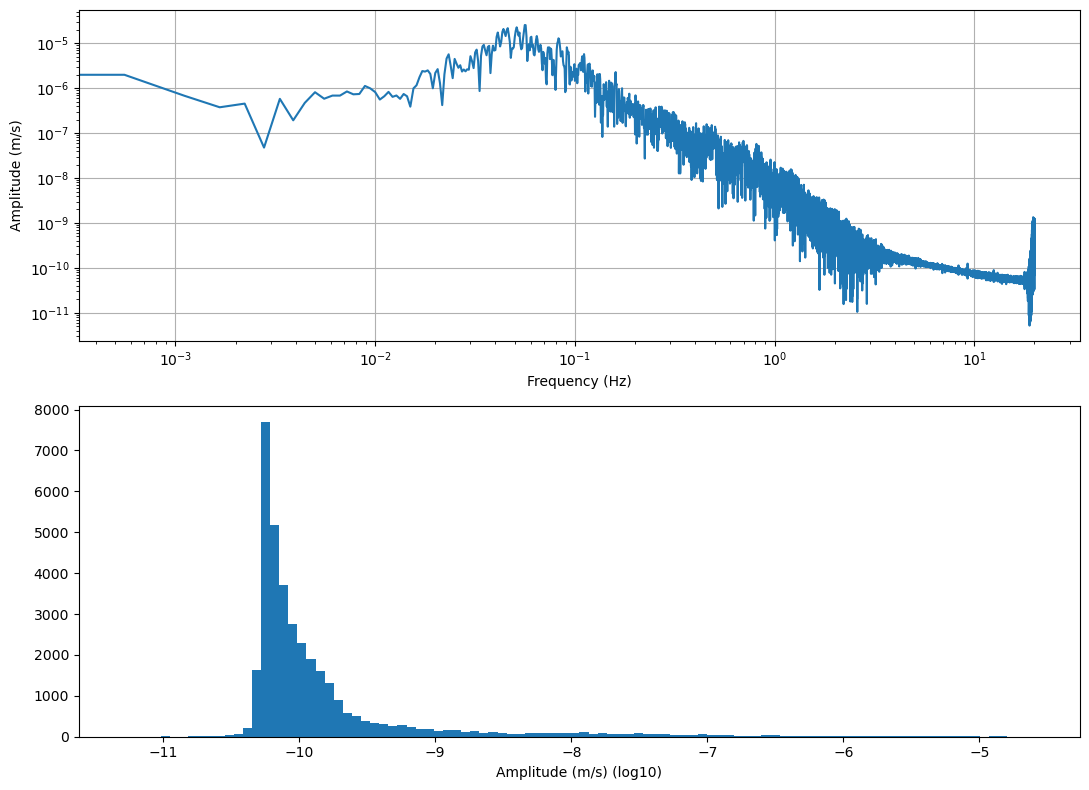

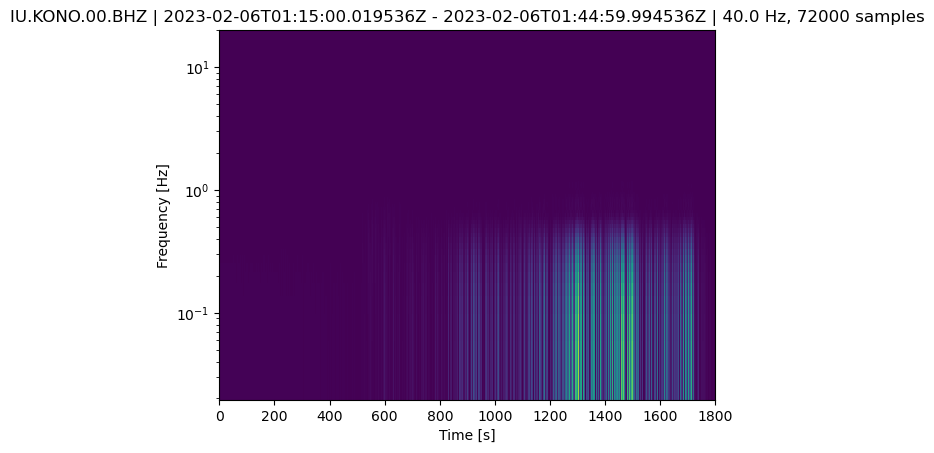

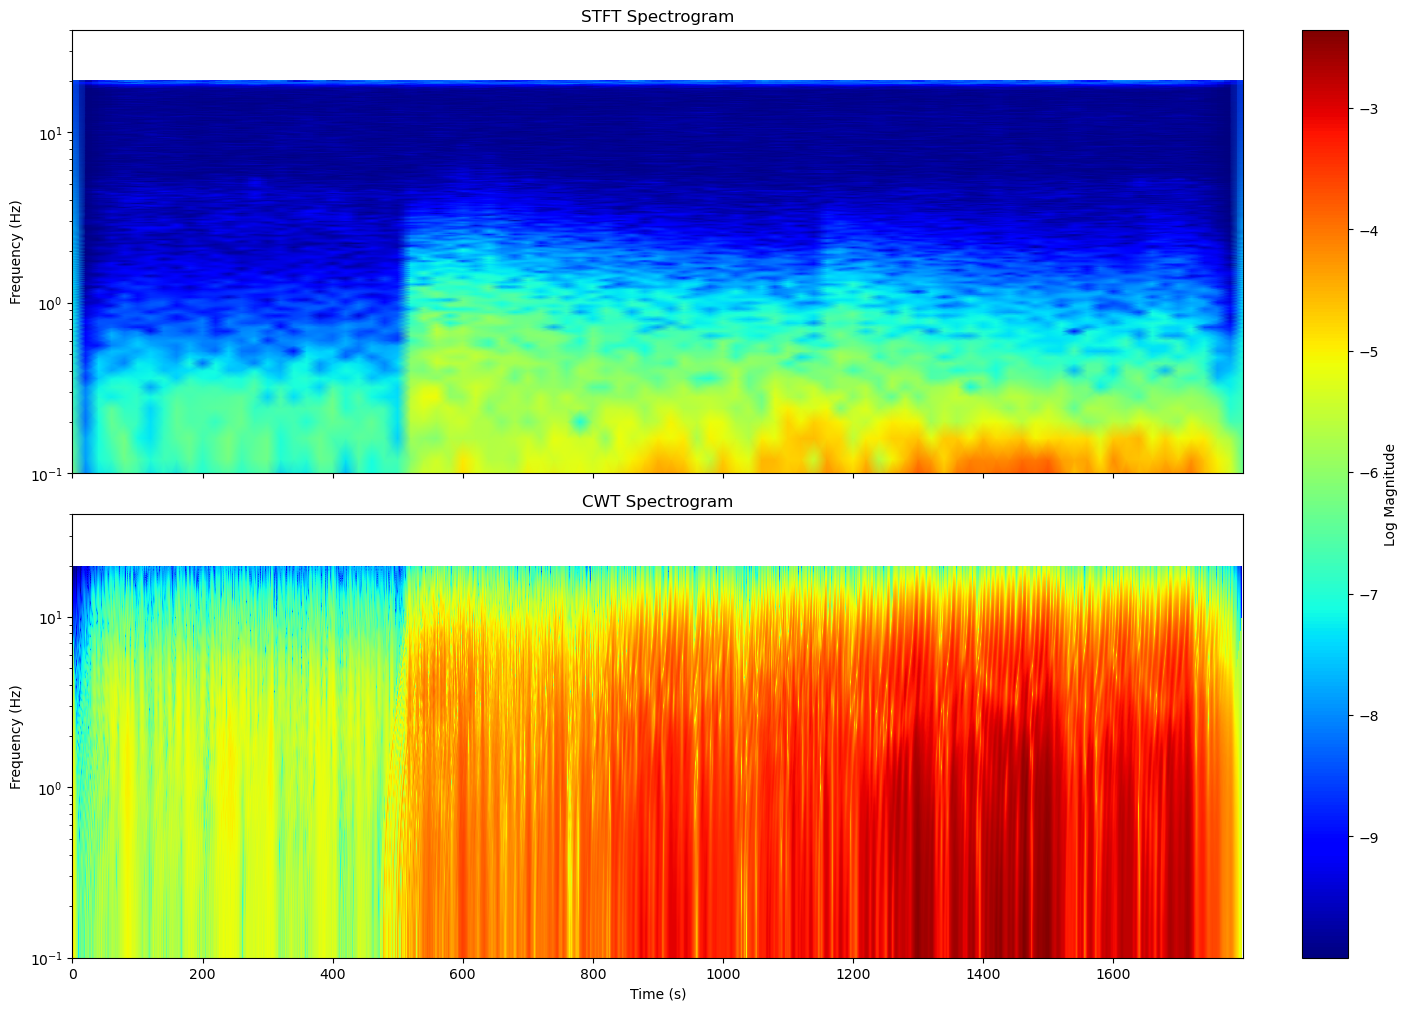

Returned 373 events


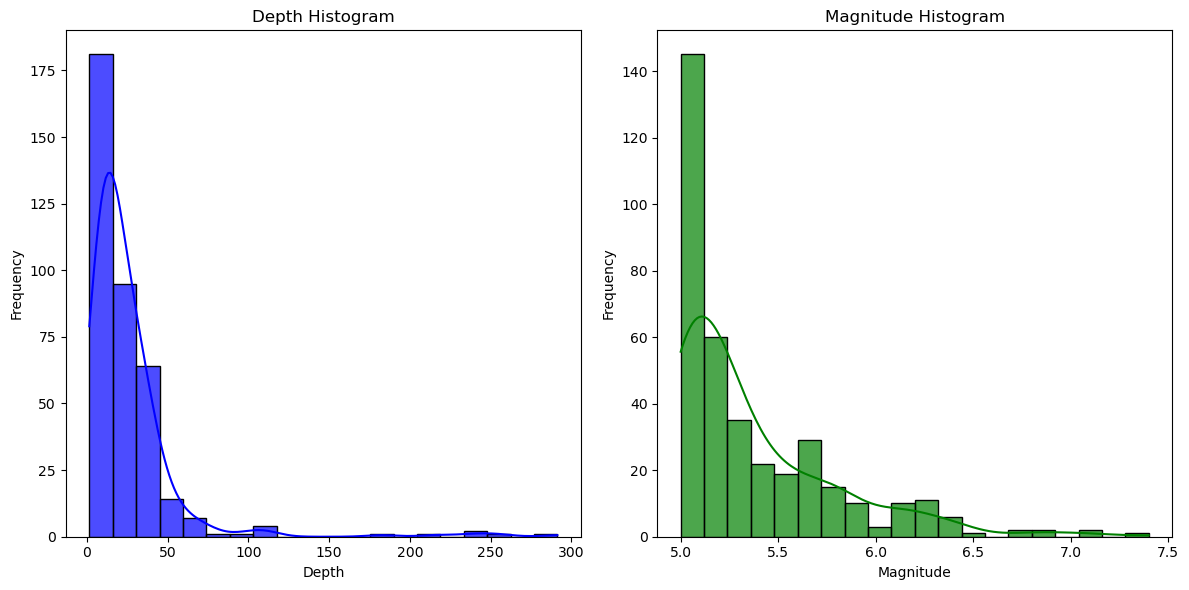

In [15]:
%pip install PyWavelets numpy matplotlib scipy obspy usgs-libcomcat datetime seaborn


# Import necessary dependencies 
import pywt 
import numpy as np 
import matplotlib.pyplot as plt 
from obspy import UTCDateTime 
from obspy.clients.fdsn import Client 
from scipy.fftpack import fft, fftfreq, next_fast_len
from scipy.signal import stft 

# Define network-station code 
network = "IU"
station = "KONO"
location = "00"
channel = "BHZ" # High-gain broadband vertical component 

# Define time window 
starttime = UTCDateTime("2023-02-06T01:15:00")
endtime = starttime + 60 * 30 # 30 minutes 

client = Client("IRIS")

# Call the specific data from IRIS 
st = client.get_waveforms(network=network, station=station, location=location, channel=channel, starttime=starttime, endtime=endtime, attach_response=True)

# Basic pre-processing: 
# Merge all data if there are gaps; detrend, taper 
# Remove the seismic instrument response; convert from the digitizer units to ground motion (velocity) units 
st.merge()
st.detrend(type='linear')
st.taper(max_percentage=0.05)
st.remove_response(output="VEL")

# Define trimmed window 
trim_start = starttime + 2 * 60 
trim_end = endtime - 5 * 60 
st.trim(starttime=starttime, endtime=endtime)

# Plot the waveform 
st.plot(); 

# Save the seismogram for later use; 'MSEED' format 
st.write("marquakes.mseed", format="MSEED")

%pip install pyrocko 
!snuffler marquakes.mseed 

# Filter the seismogram 
st2 = st.copy()
st2.filter("bandpass", freqmin=1.0, freqmax=15.0, corners=4, zerophase=True)
st2.plot();

# Get the number of samples in the Trace
npts = st[0].stats.npts  # Total number of data points (samples) in the waveform

# Find the optimal FFT length
Nfft = next_fast_len(int(st[0].data.shape[0]))

# Create a frequency vector (in Hz) up to Nyquist frequency
freqVec = fftfreq(Nfft, d=st[0].stats.delta)[:Nfft//2] # '[:Nfft//2]' keeps only the positive frequencies

# Compute the FFT of the seismic signal with zero-padding to length Nfft
st_fft = fft(st[0].data, n=Nfft) # It automatically zero-pads data

fig, ax = plt.subplots(2, 1, figsize=(11, 8))
ax[0].plot(freqVec, np.abs(st_fft[:Nfft//2])/Nfft)
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
ax[1].hist(np.log10(np.abs(st_fft[:Nfft//2])/Nfft),100)
ax[1].set_xlabel('Amplitude (m/s) (log10)')
plt.tight_layout()

# Plot the spectrogram
st.spectrogram(log=True)

# Define parameters
nperseg = 1000
noverlap = 200

# Extract data and time axis
tr = st[0]
data = tr.data
sampling_rate = tr.stats.sampling_rate
dt = 1 / sampling_rate
num_samples = len(data)
time = np.arange(0, num_samples * dt, dt)

# Perform STFT
f_stft, t_stft, Zxx = stft(data, fs=sampling_rate, nperseg=nperseg, noverlap=200)
Zxx_mag = np.log10(np.abs(Zxx) + 1e-10)  # Avoid log(0)

# Perform CWT
wavelet_name = 'cmor1.0-0.5'
central_frequency = pywt.central_frequency(wavelet_name)
min_freq = 0.1
max_freq = sampling_rate / 2
num_scales = 256
frequencies_cwt = np.logspace(np.log10(min_freq), np.log10(max_freq), num_scales)
scales = central_frequency * sampling_rate / frequencies_cwt
coefficients, _ = pywt.cwt(data, scales=scales, wavelet=wavelet_name)
cwt_mag = np.log10(np.abs(coefficients) + 1e-10)

# Shared color scale
vmin = min(Zxx_mag.min(), cwt_mag.min())
vmax = max(Zxx_mag.max(), cwt_mag.max())


fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, constrained_layout=True)

# STFT
im1 = axes[0].pcolormesh(t_stft, f_stft, Zxx_mag, vmin=vmin, vmax=vmax, shading='gouraud', cmap='jet')
axes[0].set_yscale('log')
axes[0].set_ylim(0.1, 40)
axes[0].set_ylabel("Frequency (Hz)")
axes[0].set_title("STFT Spectrogram")

# CWT
extent = [time[0], time[-1], frequencies_cwt[-1], frequencies_cwt[0]]
im2 = axes[1].imshow(cwt_mag, aspect='auto', extent=extent,
                     cmap='jet', vmin=vmin, vmax=vmax)
axes[1].set_yscale('log')
axes[1].set_ylim(0.1, 40)
axes[1].set_ylabel("Frequency (Hz)")
axes[1].set_xlabel("Time (s)")
axes[1].set_title("CWT Spectrogram")

# Colorbar (shared)
fig.colorbar(im2, ax=axes, orientation='vertical', label='Log Magnitude')

plt.show()

from datetime import datetime
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame

starttime = datetime(2000, 1, 1, 0, 0)
endtime = datetime(2025, 1, 1, 0, 0)

events = search(starttime=starttime, endtime=endtime, minmagnitude=5)
event_df = get_summary_data_frame(events)

taiwan_events = event_df[event_df['location'].str.contains('Taiwan', case=False)] # Select ones that contain the word 'Taiwan'

print("Returned %s events" % len(taiwan_events))

taiwan_events.head()

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Depth histogram with KDE
sns.histplot(data=taiwan_events, x='depth', bins=20, kde=True, color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title('Depth Histogram')
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('Frequency')

# Magnitude histogram with KDE
sns.histplot(data=taiwan_events, x='magnitude', bins=20, kde=True, color='green', alpha=0.7, ax=axes[1])
axes[1].set_title('Magnitude Histogram')
axes[1].set_xlabel('Magnitude')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Notebook Setup


In [16]:
%pip install PyWavelets numpy matplotlib scipy obspy usgs-libcomcat datetime seaborn

Note: you may need to restart the kernel to use updated packages.


In [17]:

# Import necessary dependencies 
import pywt 
import numpy as np 
import matplotlib.pyplot as plt 
from obspy import UTCDateTime 
from obspy.clients.fdsn import Client 
from scipy.fftpack import fft, fftfreq, next_fast_len
from scipy.signal import stft 

# The Turkey-Syria Earthquake 
### The Turkey-Syria Earthquake occured on 6 February 2024, with a magnitude (Mw) of 7.8. The Earthquake struck southern and central Turkey and northern and western Syria. The epicenter was 37km west-northwest of Gaziantep (a major city in south-central Turkey). 

In [18]:
# Define network-station code 
network = "IU"
station = "KONO"
location = "00"
channel = "BHZ" # High-gain broadband vertical component 

# Define time window 
starttime = UTCDateTime("2023-02-06T01:15:00")
endtime = starttime + 60 * 30 # 30 minutes 

client = Client("IRIS")

# Call the specific data from IRIS 
st = client.get_waveforms(network=network, station=station, location=location, channel=channel, starttime=starttime, endtime=endtime, attach_response=True)

# Basic pre-processing: 
# Merge all data if there are gaps; detrend, taper 
# Remove the seismic instrument response; convert from the digitizer units to ground motion (velocity) units 
st.merge()
st.detrend(type='linear')
st.taper(max_percentage=0.05)
st.remove_response(output="VEL")

# Define trimmed window 
trim_start = starttime + 2 * 60 
trim_end = endtime - 5 * 60 
st.trim(starttime=starttime, endtime=endtime)

1 Trace(s) in Stream:
IU.KONO.00.BHZ | 2023-02-06T01:15:00.019536Z - 2023-02-06T01:44:59.994536Z | 40.0 Hz, 72000 samples

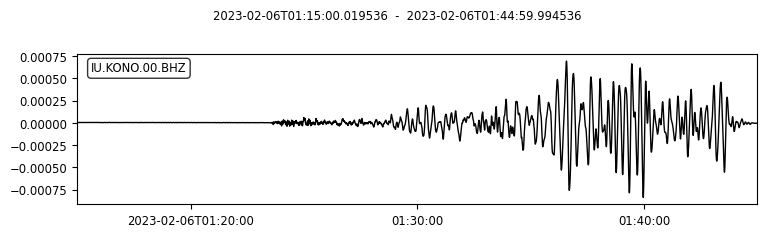

/opt/miniconda3/envs/mapmaking_env/lib/python3.11/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [19]:
# Plot the waveform 
st.plot(); 

# Save the seismogram for later use; 'MSEED' format 
st.write("marquakes.mseed", format="MSEED")


In [20]:
%pip install pyrocko 
!snuffler marquakes.mseed 

Note: you may need to restart the kernel to use updated packages.
snuffler:pyrocko.gui.snuffler.snuffler - CRITICAL - 

Missing Pyrocko requirement: PyQt5

The Python package 'PyQt5' is required to run this program, but it doesn't seem to
be available or an error occured while importing it. Use your package manager
of choice (apt / yum / conda / pip) to install it. To verify that 'PyQt5' is
available in your Python environment, check that "python -c 'import PyQt5.Qt'"
exits without error. The original error was:

  No module named 'PyQt5'



/opt/miniconda3/envs/mapmaking_env/lib/python3.11/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


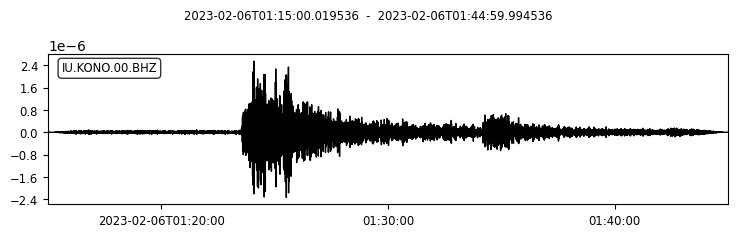

In [21]:
# Filter the seismogram 
st2 = st.copy()
st2.filter("bandpass", freqmin=1.0, freqmax=25.0, corners=4, zerophase=True)
st2.plot();

# FFT 

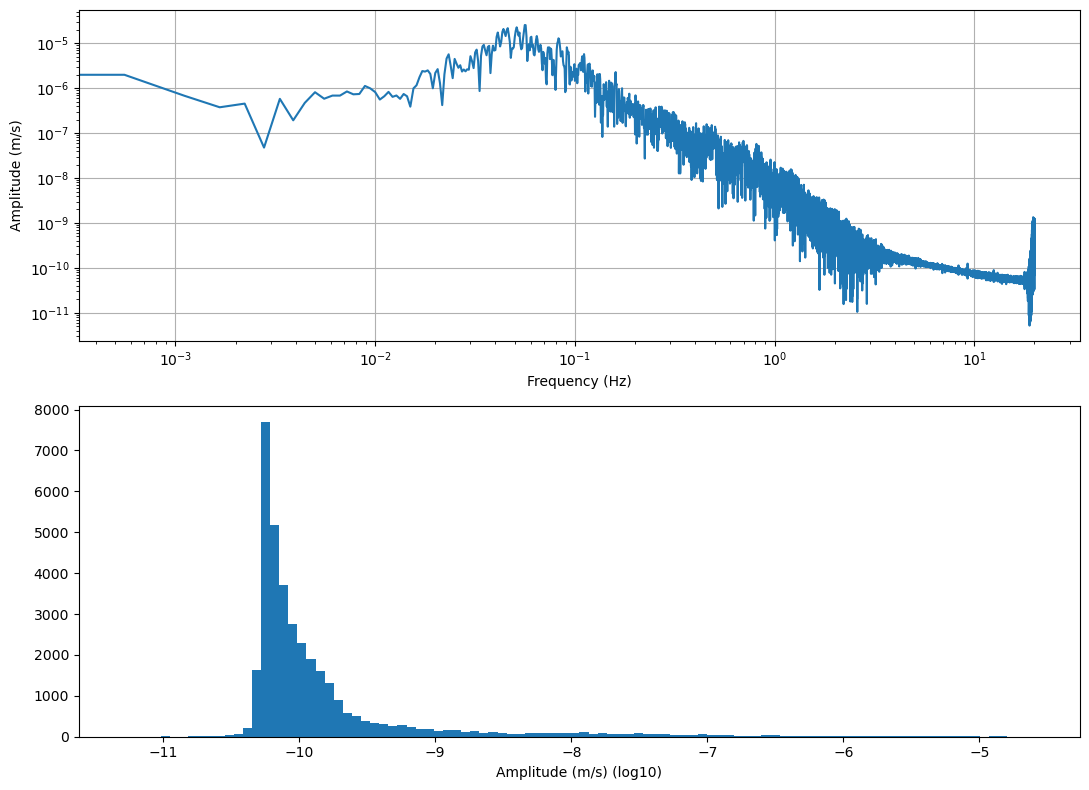

In [22]:
# Get the number of samples in the Trace
npts = st[0].stats.npts  # Total number of data points (samples) in the waveform

# Find the optimal FFT length
Nfft = next_fast_len(int(st[0].data.shape[0]))

# Create a frequency vector (in Hz) up to Nyquist frequency
freqVec = fftfreq(Nfft, d=st[0].stats.delta)[:Nfft//2] # '[:Nfft//2]' keeps only the positive frequencies

# Compute the FFT of the seismic signal with zero-padding to length Nfft
st_fft = fft(st[0].data, n=Nfft) # It automatically zero-pads data

fig, ax = plt.subplots(2, 1, figsize=(11, 8))
ax[0].plot(freqVec, np.abs(st_fft[:Nfft//2])/Nfft)
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
ax[1].hist(np.log10(np.abs(st_fft[:Nfft//2])/Nfft),100)
ax[1].set_xlabel('Amplitude (m/s) (log10)')
plt.tight_layout()

# Spectograms 

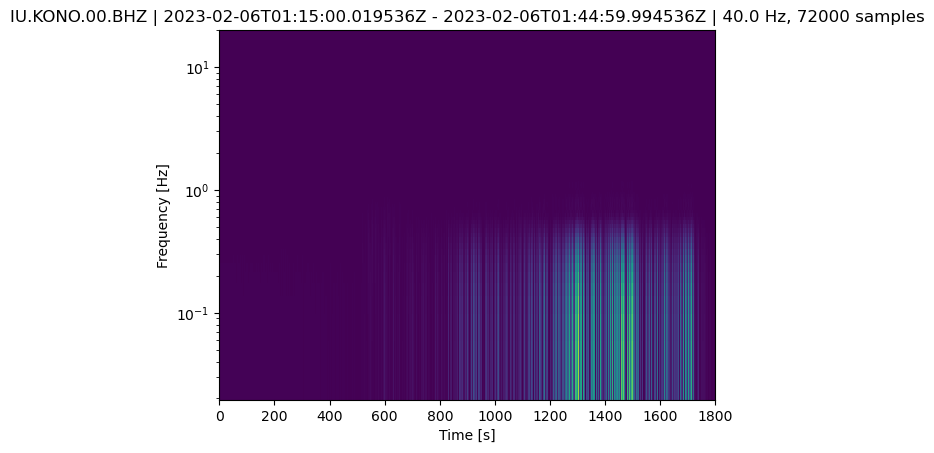

[None]

In [23]:
# Plot the spectrogram
st.spectrogram(log=True)

# Compare STFT and CWT 

In [24]:
# Define parameters 
nperseg = 1000
noverlap = 200 

# Extract data and time axis 
tr = st[0]
data = tr.data 
sampling_rate = tr.stats.sampling_rate
dt = 1 / sampling_rate
num_samples = len(data)
time = np.arange(0, num_samples * dt, dt)

# Perform STFT
f_stft, t_stft, Zxx = stft(data, fs=sampling_rate, nperseg=nperseg, noverlap=200)
Zxx_mag = np.log10(np.abs(Zxx) + 1e-10)  # Avoid log(0)

# Perform CWT
wavelet_name = 'cmor1.0-0.5'
central_frequency = pywt.central_frequency(wavelet_name)
min_freq = 0.1
max_freq = sampling_rate / 2
num_scales = 256
frequencies_cwt = np.logspace(np.log10(min_freq), np.log10(max_freq), num_scales)
scales = central_frequency * sampling_rate / frequencies_cwt
coefficients, _ = pywt.cwt(data, scales=scales, wavelet=wavelet_name)
cwt_mag = np.log10(np.abs(coefficients) + 1e-10)

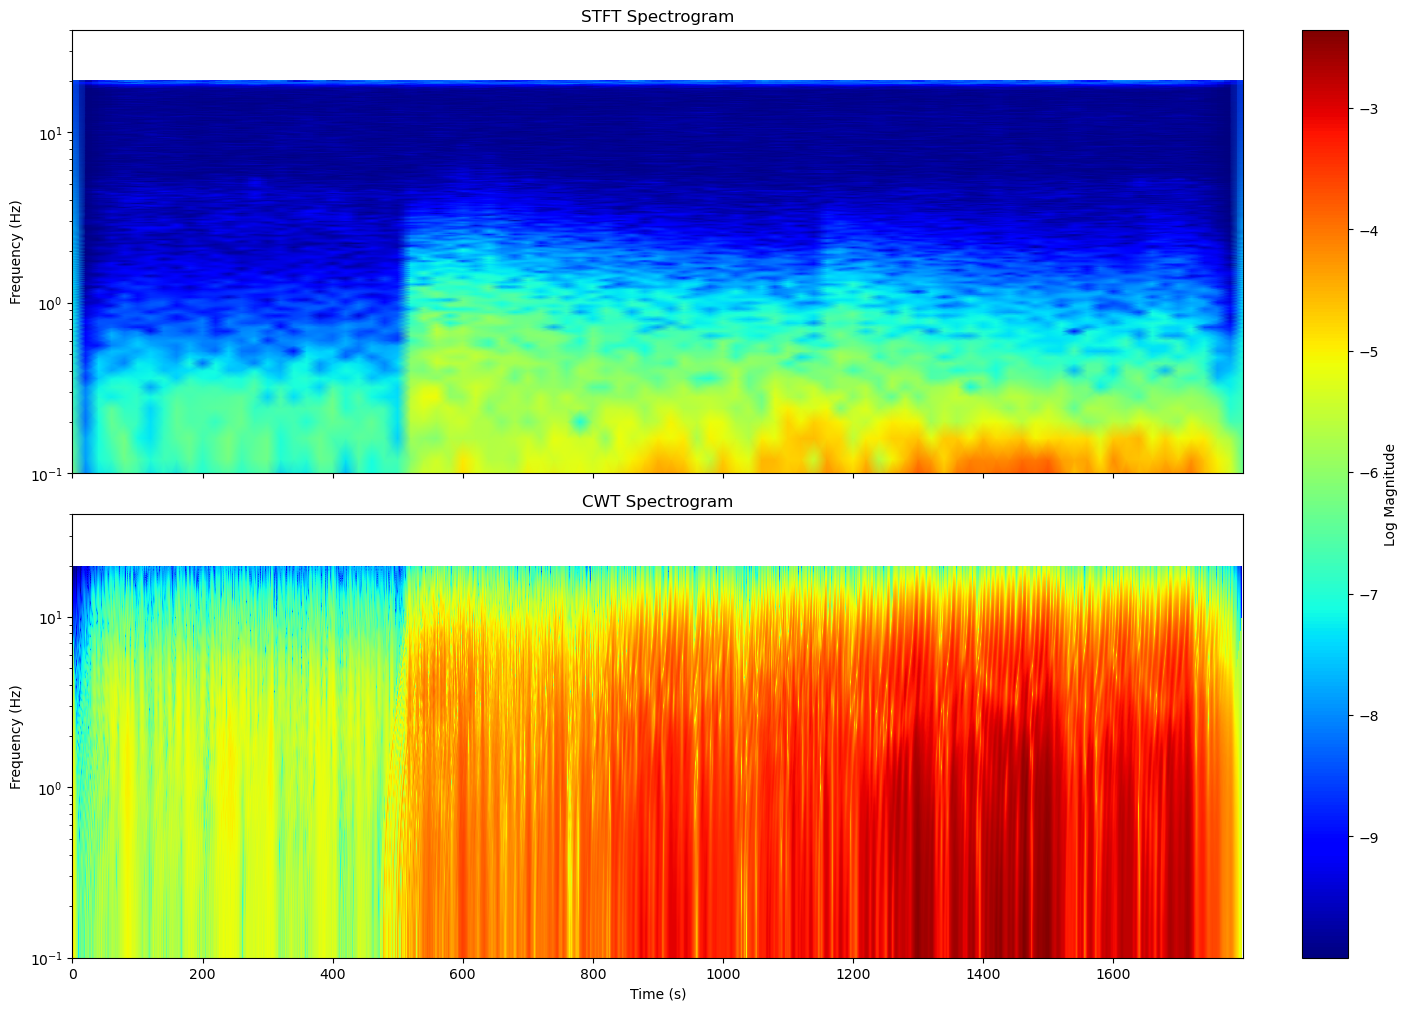

In [25]:
# Shared color scale
vmin = min(Zxx_mag.min(), cwt_mag.min())
vmax = max(Zxx_mag.max(), cwt_mag.max())


fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, constrained_layout=True)

# STFT
im1 = axes[0].pcolormesh(t_stft, f_stft, Zxx_mag, vmin=vmin, vmax=vmax, shading='gouraud', cmap='jet')
axes[0].set_yscale('log')
axes[0].set_ylim(0.1, 40)
axes[0].set_ylabel("Frequency (Hz)")
axes[0].set_title("STFT Spectrogram")

# CWT
extent = [time[0], time[-1], frequencies_cwt[-1], frequencies_cwt[0]]
im2 = axes[1].imshow(cwt_mag, aspect='auto', extent=extent,
                     cmap='jet', vmin=vmin, vmax=vmax)
axes[1].set_yscale('log')
axes[1].set_ylim(0.1, 40)
axes[1].set_ylabel("Frequency (Hz)")
axes[1].set_xlabel("Time (s)")
axes[1].set_title("CWT Spectrogram")

# Colorbar (shared)
fig.colorbar(im2, ax=axes, orientation='vertical', label='Log Magnitude')

plt.show()



# Earthquake Archive

In [26]:
from datetime import datetime
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame

# Approximate time window around the 2025 Mandalay Earthquake 
starttime = datetime(2025, 3, 1, 0, 0)
endtime = datetime(2025, 4, 15, 0, 0)

# Define search with minimum magnitude and region keywords
events = search(
    starttime=starttime,
    endtime=endtime,
    minmagnitude=5.0,
    maxlatitude=25.7,   # North of Myanmar
    minlatitude=15.0,   # South of Myanmar
    maxlongitude=100.0, # East of Myanmar
    minlongitude=92.0   # West of Myanmar
)

# Convert results to dataframes 
event_df = get_summary_data_frame(events)

myanmar_events = event_df[event_df['location'].str.contains('Myanmar', case=False)] # Select ones that contain the word 'Myanmar'

# Display result
print("Returned %s events in/near Myanmar" % len(myanmar_events))



Returned 5 events in/near Myanmar


In [27]:
myanmar_events.head()

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
0,us6000pwx1,2025-03-04 22:06:43.695000+00:00,"15 km S of Nyaungdon, Burma (Myanmar)",16.9032,95.6230,10.0,5.1,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,414
3,us7000pn9s,2025-03-28 06:20:52.709000+00:00,"2025 Mandalay, Burma (Myanmar) Earthquake",22.0014,95.9247,10.0,7.7,red,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,2910
4,us7000pn9z,2025-03-28 06:32:04.777000+00:00,Burma (Myanmar),21.6975,95.9690,10.0,6.7,red,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,2104
5,us7000pnkj,2025-03-29 09:20:48.229000+00:00,"8 km SW of Nay Pyi Taw, Burma (Myanmar)",19.6858,96.0761,10.0,5.1,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,405
6,us6000q5ps,2025-04-13 02:24:57.717000+00:00,"41 km S of Kyaukse, Burma (Myanmar)",21.2292,96.0897,10.0,5.3,orange,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,1023


In [ ]:
import matplotlib.pylot as plt 
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Depth histogram with KDE 
sns.histplot(data=myanmar_events, x='depth', bins=20, kde=True, color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title('Depth Histogram')
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('Frequency')

# Magnitude histogram with KDE 
sns.histplot(data=myanmar_events, x='magnitude', bins=20, kde=True, color='green', alpha=0.7, ax=axes[1])
axes[1].set_title('Magnitude Histogram')
axes[1].set_xlabel('Magnitude')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'matplotlib.pylot'